In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels import api as sm
from pykalman import KalmanFilter
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statistics import mean
from datetime import timedelta
from sklearn.metrics import mean_squared_error


from datetime import date
import datetime
import holidays

In [2]:
# statusデータ
status = pd.read_csv('../../../status.csv')

In [3]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)


status_v0 = status[status['station_id'] == 0] 
status_v0 = status_v0[status_v0['date'] >= '2013-10-01']
status_v0 = status_v0[status_v0['date'] < '2013-11-01']

status_v1 = status_v0.set_index('date')
status_v2 = status_v1['bikes_available']

status_test = status[status['station_id'] == 0] 
status_test = status_test[status_test['date'] >= '2013-10-01']
status_test = status_test[status_test['date'] < '2013-11-08']
status_test_v1 = status_test.set_index('date')
status_test_v2 = status_test_v1['bikes_available']

status_v2

date
2013-10-01 00:00:00    16.0
2013-10-01 01:00:00    14.0
2013-10-01 02:00:00    14.0
2013-10-01 03:00:00    14.0
2013-10-01 04:00:00    14.0
                       ... 
2013-10-31 19:00:00    19.0
2013-10-31 20:00:00    18.0
2013-10-31 21:00:00    18.0
2013-10-31 22:00:00    18.0
2013-10-31 23:00:00    17.0
Name: bikes_available, Length: 744, dtype: float64

<AxesSubplot:xlabel='date'>

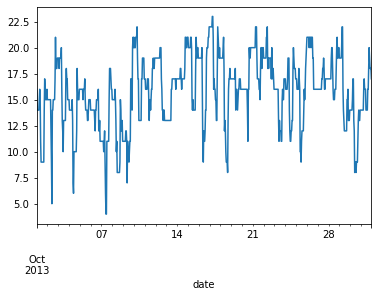

In [4]:
status_v2.plot()

In [5]:
# 推移行列などの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
  
    # 各行列のトレンド成分に対するブロック行列を構築
    G[0,0] = 1
    H[0,0] = 1
    
    # トレンドモデルの推移行列の構築
    # 非定常過程でも対応できる推移行列を構築 
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [6]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs)

In [7]:
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

In [8]:
n_train = 120
train_data, test_data = status_v2.values[:n_train], status_v2.values[n_train:240]

In [9]:
true_data = status_v2.values[:240]

In [10]:
smoothed_state_means, smoothed_state_covs = kf.smooth(train_data)
pred_o_smoothed = smoothed_state_means.dot(H.T)

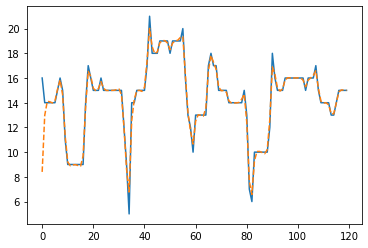

In [11]:
plt.plot(train_data, label="observation")
plt.plot(pred_o_smoothed, '--', label="predict")

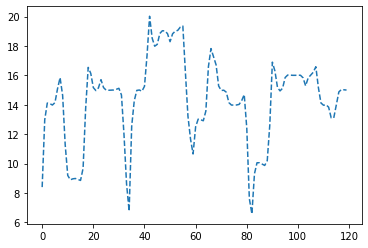

In [12]:
plt.plot(pred_o_smoothed, '--', label="predict")

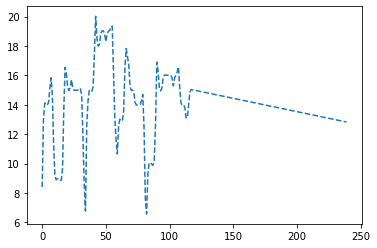

In [13]:
#plt.plot(y.values, label="observation")

# 長期予測格納用のベクトルを用意（値は全て入れ替わるため0で初期化しなくてよい）
pred_y = np.empty(len(train_data))

# 現在の状態と分散共分散行列を取得
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test_data)):
    # filter_updateは観測値を入力しなければ1期先予測のみを実行する
    current_state, current_cov = kf.filter_update(current_state, 
                                                  current_cov, 
                                                  observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)
    
# np.hstackはnp.concatenateでもよい
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

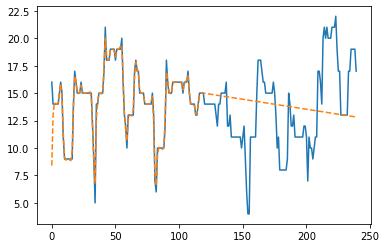

In [14]:
plt.plot(true_data)
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

In [15]:
len(test_data)

120

In [16]:
len(pred_y)

120

In [17]:
#3.2.2

In [18]:
# 推移行列などの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1
    
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [19]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の次元数
n_dim_series = 12

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs, n_dim_series)

In [20]:
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

In [21]:
# フィルタ＋平滑化
smoothed_state_means, smoothed_state_covs = kf.smooth(train_data)
pred_o_smoothed = smoothed_state_means.dot(H.T)

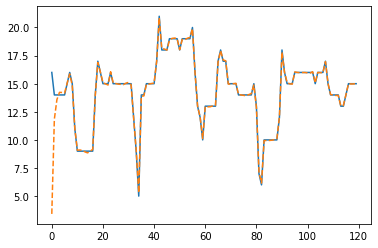

In [22]:
plt.plot(train_data, label="observation")
plt.plot(pred_o_smoothed, '--', label="predict")

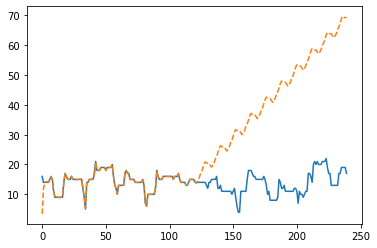

In [23]:
plt.plot(true_data, label="observation")

pred_y = np.empty(len(test_data))
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test_data)):
    current_state, current_cov = kf.filter_update(current_state, 
                                                  current_cov, 
                                                  observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)
    
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

In [24]:
# 繰り返し回数は10回
# ハイパーパラメタ更新の対象はF, H, Q, R
emed_kf = kf.em(train_data, n_iter=10, em_vars='all')

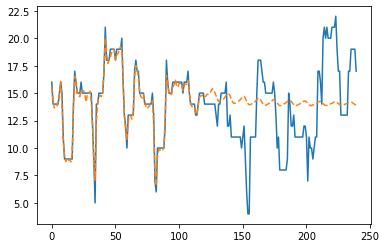

In [25]:
# ハイパーパラメタF, H, Q, R更新後の平滑化系列
em_smoothed_state_means, em_smoothed_state_covs = emed_kf.smooth(train_data)
em_pred_o_smoothed = np.dot(em_smoothed_state_means, emed_kf.observation_matrices.T)
plt.plot(true_data, label="observation")

current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

pred_y = np.empty(len(test_data))
for i in range(len(test_data)):
    current_state, current_cov = emed_kf.filter_update(current_state, current_cov, observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)

plt.plot(np.hstack([em_pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

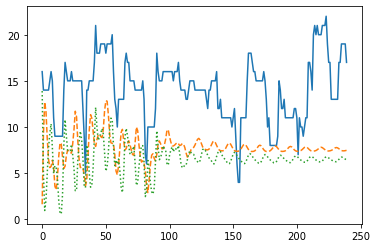

In [26]:
# 階差
diff = 1

# トレンド成分
# トレンド成分では階差の次数分の状態が対象
t_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, :diff], 
                              emed_kf.observation_matrices[:, :diff].T)
# 季節成分
# 季節成分は状態ベクトルにおいてトレンド成分以降の要素が対象
s_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, diff:], 
                              emed_kf.observation_matrices[:, diff:].T)

current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

# トレンド成分と季節成分の長期予測値を格納するベクトルを用意
t_pred_y = np.empty(len(test_data))
s_pred_y = np.empty(len(test_data))
# トレンド成分および季節成分の長期予測
for i in range(len(test_data)):
    current_state, current_cov = emed_kf.filter_update(current_state, 
                                                       current_cov, 
                                                       observation=None)
    t_pred_y[i] = \
        emed_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = \
        emed_kf.observation_matrices[:, diff:].dot(current_state[diff:])

plt.plot(true_data, label="observation")
plt.plot(np.hstack([t_em_pred_o_smoothed.flatten(), t_pred_y]),
         '--', label="trend")
plt.plot(np.hstack([s_em_pred_o_smoothed.flatten(), s_pred_y]),
         ':', label="seasonal")

# トレンド成分＋季節成分の表示をしたい場合は以下のコメントアウトを外す
# plt.plot(
#     np.hstack([
#         s_em_pred_o_smoothed.flatten()+t_em_pred_o_smoothed.flatten(),
#         s_pred_y+t_pred_y]),
#     '+-', label="forecast")

In [27]:
emed_kf.observation_matrices.dot(em_smoothed_state_covs).shape

(1, 120, 13)

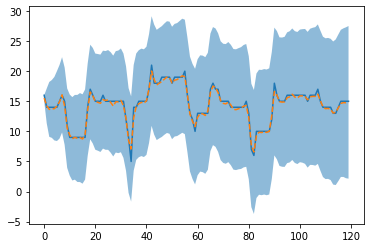

In [28]:
from scipy.stats import norm

# n_trainは訓練時点数
n_train = len(em_smoothed_state_covs)

# y_tの予測分布の分散
pred_cov = emed_kf.observation_matrices.dot(
    np.abs(em_smoothed_state_covs)).transpose(1,0,2).dot(emed_kf.observation_matrices.T)
# y_tの予測分布の平均
pred_mean = em_smoothed_state_means.dot(emed_kf.observation_matrices.T)

# 訓練データにおける推定値の95%信用区間の上下限
lower, upper = norm.interval(0.95, pred_mean.flatten(), scale=np.sqrt(pred_cov.flatten()))

plt.plot(train_data, label="observation")
plt.plot(em_pred_o_smoothed, '--', label="predict")
plt.fill_between(range(len(train_data)), upper,lower, alpha=0.5, label="credible interval")

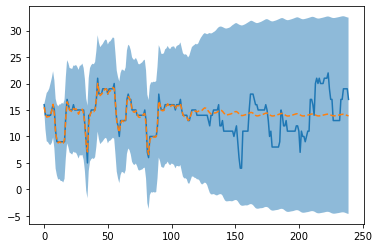

In [29]:
# 階差
diff = n_dim_trend
se = n_dim_trend + n_dim_series - 1
# トレンド成分
t_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, :diff], emed_kf.observation_matrices[:, :diff].T)
# 季節成分
s_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, diff:se], emed_kf.observation_matrices[:, diff:se].T)

current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

# 訓練データ数
n_test = len(test_data)
# 長期予測系列を保存するベクトル
# トレンド成分
t_pred_y = np.empty(n_test)
# 季節成分
s_pred_y = np.empty(n_test)
# 95%信用区間の下限
inf_lower = np.empty(n_test)
# 95%信用区間の上限
inf_upper = np.empty(n_test)

# トレンド成分および季節成分の長期予測
for i in range(len(test_data)):
    current_state, current_cov = emed_kf.filter_update(current_state, current_cov, observation=None)
    t_pred_y[i] = emed_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = emed_kf.observation_matrices[:, diff:se].dot(current_state[diff:se])

    # y_tの予測分布の分散
    pred_cov = emed_kf.observation_matrices.dot(np.abs(current_cov)).dot(emed_kf.observation_matrices.T)
    # y_tの予測分布の平均
    pred_mean = current_state.dot(emed_kf.observation_matrices.T)
    inf_lower[i], inf_upper[i] = norm.interval(0.95, pred_mean, scale=np.sqrt(pred_cov))
    
plt.plot(true_data, label="observation")
plt.plot(np.hstack([em_pred_o_smoothed.flatten(), t_pred_y+s_pred_y]), '--', label="forecast")
all_lower = np.hstack([lower, inf_lower])
all_upper = np.hstack([upper, inf_upper])
plt.fill_between(range(len(true_data)), all_upper, all_lower, alpha=0.5, label="credible interval")

In [30]:
#3.2.3

In [31]:
# 推移行列などの初期化
def FGHset(n_dim_trend, 
           n_dim_obs=1, n_dim_series=0, n_dim_ar=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0) + (n_dim_ar!=0)
    if n_dim_series>0 or n_dim_ar>0:
        n_dim_state = n_dim_trend + n_dim_series + n_dim_ar - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1

        start_elem = n_dim_trend + n_dim_series - 1
        start_col = n_dim_trend + n_dim_series - 1
            
    # AR成分のブロック行列の構築
    if n_dim_ar>0:
        G[start_elem, 2] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_ar): 
            F[start_elem, start_elem+i] = 0
        for i in range(n_dim_ar-1): 
            F[start_elem+i+1, start_elem+i] = 1

            
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [32]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の次元数
n_dim_series = 12
# AR成分の次元数
n_dim_ar = 2

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs, n_dim_series, n_dim_ar)

In [33]:
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

In [34]:
# フィルタ＋平滑化
smoothed_state_means, smoothed_state_covs = kf.smooth(train_data)
pred_o_smoothed = smoothed_state_means.dot(H.T)

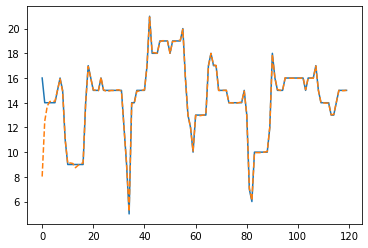

In [35]:
plt.plot(train_data, label="observation")
plt.plot(pred_o_smoothed, '--', label="predict")

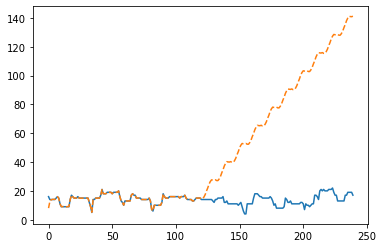

In [36]:
plt.plot(true_data, label="observation")

pred_y = np.empty(len(test_data))
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test_data)):
    current_state, current_cov = kf.filter_update(current_state, 
                                                  current_cov, 
                                                  observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)
    
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

In [37]:
from scipy.optimize import minimize
import copy


# parcorを用いたAR係数の推定
def ar_coef(parcor, n_dim_ar):
    ar_hat = np.zeros(n_dim_ar)
    am = np.zeros(n_dim_ar)
    if n_dim_ar==1:
        ar_hat = parcor
    else:
        for i in range(n_dim_ar):
            ar_hat[i] = parcor[i]
            am[i] = parcor[i]
            if i > 0:
                for j in range(i-1):
                    # m次のj番目の係数の算出
                    # am[j]はm-1次のj番目の係数
                    # am[i-j]はm-j次のm-j番目の係数
                    ar_hat[j] = am[j] - parcor[i] * am[i-j]
                if i < n_dim_ar-1:
                    for j in range(i-1):
                        am[j] = ar_hat[j]
    return ar_hat


# AR係数最適化のための対数尤度の計算
def ar_n_minimize_likelihood(target, kf, train_data, 
                             idx_target_parcor, st_row, st_col):
    kf.transition_matrices[st_row, st_col+idx_target_parcor] = target
    kf.smooth(train_data)

    # "masked arrays are not supported"というエラーが発生した場合は
    # https://github.com/pykalman/pykalman/issues/83
    # などを参照してPykalmanのコードを修正してほしい
    return -kf.loglikelihood(train_data)


# システムノイズの分散共分散行列最適化のための対数尤度の計算
def Q_minimize_likelihood(targets, kf, train_data, target_idx):
    for i, (r,c) in enumerate(target_idx):
        kf.transition_covariance[r, c] = targets[i]
    kf.smooth(train_data)
    return -kf.loglikelihood(train_data)


n_q = 2
# トレンド成分、季節成分、AR成分の分散の最適化の範囲
q_bnds = ((1e-4, 1e3),) * (n_q) + ((1e-4, 5e1),)
# AR成分の最適化の範囲
ar_bnds = ((-0.95, 0.95), )
# 行列GのAR成分成分の位置
st_row = n_dim_trend + n_dim_series - 1
st_col = n_dim_trend + n_dim_series - 1
# 最適化の繰り返し回数
n_iter = 2

# ハイパーパラメタ調整前のモデルを残すために
# オブジェクトをコピーしておく
q_kf = copy.deepcopy(kf)

In [38]:
# AR成分を個別に最適化
for idx_target_parcor in range(n_dim_ar):
    ar_idx_end = st_col + idx_target_parcor
    for i_opt in range(n_iter):
        if idx_target_parcor > 0:
            ar_args = q_kf.transition_matrices[st_row, 
                                               st_col:ar_idx_end]
            ar_cov = [q_kf.transition_covariance[st_row+i, st_col+i] 
                      for i in range(idx_target_parcor)]

        if i_opt==0:
            q_kf = copy.deepcopy(kf)
            
        if idx_target_parcor > 0:
            q_kf.transition_matrices[st_row, st_col:ar_idx_end] = ar_args
            for i in range(idx_target_parcor):
                q_kf.transition_covariance[st_row+i, st_col+i] = ar_cov[i]

        args = (q_kf, train_data, idx_target_parcor, st_row, st_col)
        # 対象のparcorの係数の最適化
        minimize(ar_n_minimize_likelihood, 
                 (0.,), 
                 args=args, 
                 method='SLSQP', 
                 bounds=ar_bnds)

        q_args = (q_kf, train_data, [(st_row, st_col)])
        # AR成分の分散共分散行列の要素の最適化
        minimize(Q_minimize_likelihood, 
                 (0., ), 
                 args=q_args, 
                 method='SLSQP', 
                 bounds=(q_bnds[2],))

        q_args = (q_kf, train_data, [(n_dim_trend, n_dim_trend)])
        # 季節成分の分散共分散行列の要素の最適化
        minimize(Q_minimize_likelihood,
                 (0.,),
                 args=q_args,
                 method='SLSQP',
                 bounds=(q_bnds[1],))

        q_args = (q_kf, train_data, [(0, 0)])
        # トレンド成分の分散共分散行列の要素の最適化
        minimize(Q_minimize_likelihood,
                 (0.,),
                 args=q_args,
                 method='SLSQP',
                 bounds=(q_bnds[0],))
        
        if idx_target_parcor==0:
            q_kf.transition_matrices[st_row, st_col] = \
                ar_coef(q_kf.transition_matrices[st_row, st_col], 1)
        else:
            q_kf.transition_matrices[st_row, st_col:ar_idx_end+1] = \
                ar_coef(q_kf.transition_matrices[st_row,
                                                 st_col:ar_idx_end+1],
                        idx_target_parcor+1)

In [39]:
np.diag(q_kf.transition_covariance)

array([1.00014901e-04, 0.00000000e+00, 1.00014901e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.81296646e+00, 0.00000000e+00])

In [40]:
optmed_q_kf = copy.deepcopy(q_kf)

In [42]:
optm_smoothed_state_means, optm_smoothed_state_covs = optmed_q_kf.smooth(train_data)
optm_pred_o_smoothed = np.dot(optm_smoothed_state_means, 
                              optmed_q_kf.observation_matrices.T)

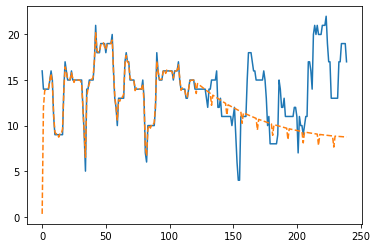

In [44]:
current_state = optm_smoothed_state_means[-1]
current_cov = optm_smoothed_state_covs[-1]

pred_y = np.empty(len(test_data))
for i in range(len(test_data)):
    current_state, current_cov = optmed_q_kf.filter_update(current_state, 
                                                           current_cov, 
                                                           observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)

plt.plot(true_data, label="observation")
plt.plot(np.hstack([optm_pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

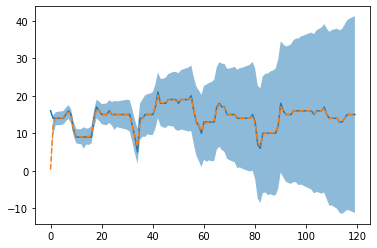

In [45]:
from scipy.stats import norm

# y_tの予測分布の分散
pred_cov = \
    optmed_q_kf.observation_matrices.dot(np.abs(optm_smoothed_state_covs)) \
                                    .transpose(1,0,2) \
                                    .dot(optmed_q_kf.observation_matrices.T)
# y_tの予測分布の平均
pred_mean = optm_smoothed_state_means.dot(optmed_q_kf.observation_matrices.T)
# 95%信用区間の上下限
lower, upper = norm.interval(0.95, 
                             pred_mean.flatten(), 
                             scale=np.sqrt(pred_cov.flatten()))

plt.plot(train_data, label="observation")
plt.plot(optm_pred_o_smoothed, '--', label="forecast")
plt.fill_between(range(len(train_data)), upper, lower,alpha=0.5, label="credible interval")

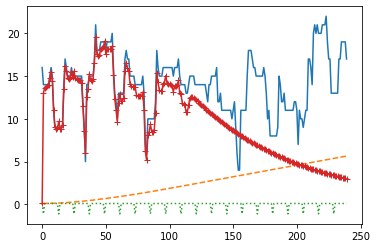

In [48]:
# 階差
diff = n_dim_trend
se = n_dim_trend + n_dim_series -1
# トレンド成分
t_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, :diff], 
                                optmed_q_kf.observation_matrices[:, :diff].T)
# 季節成分
s_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, diff:se], 
                                optmed_q_kf.observation_matrices[:, diff:se].T)
# AR成分
ar_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, se:], 
                                 optmed_q_kf.observation_matrices[:, se:].T)

current_state = optm_smoothed_state_means[-1]
current_cov = optm_smoothed_state_covs[-1]

t_pred_y = np.empty(len(test_data))
s_pred_y = np.empty(len(test_data))
ar_pred_y = np.empty(len(test_data))
# トレンド成分および季節成分の長期予測
for i in range(len(test_data)):
    current_state, current_cov = optmed_q_kf.filter_update(current_state, 
                                                           current_cov, 
                                                           observation=None)
    t_pred_y[i] = optmed_q_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = optmed_q_kf.observation_matrices[:, diff:se].dot(current_state[diff:se])
    ar_pred_y[i] = optmed_q_kf.observation_matrices[:, se:].dot(current_state[se:])

plt.plot(true_data, label="training data")
plt.plot(np.hstack([t_optm_pred_o_smoothed.flatten(), t_pred_y]), 
         '--', 
         label="predicted trend")
plt.plot(np.hstack([s_optm_pred_o_smoothed.flatten(), s_pred_y]), 
         ':', 
         label="predicted seasonal")
plt.plot(np.hstack([ar_optm_pred_o_smoothed.flatten(), ar_pred_y]), 
         '+-', 
         label="predicted ar")

In [49]:
np.diag(optmed_q_kf.transition_covariance)

array([1.00014901e-04, 0.00000000e+00, 1.00014901e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.81296646e+00, 0.00000000e+00])

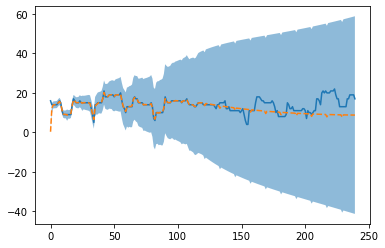

In [51]:
# 階差
diff = n_dim_trend
se = n_dim_trend + n_dim_series -1
# トレンド成分
t_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, :diff], 
                                optmed_q_kf.observation_matrices[:, :diff].T)
# 季節成分
s_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, diff:se], 
                                optmed_q_kf.observation_matrices[:, diff:se].T)
# AR成分
ar_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, se:], 
                                 optmed_q_kf.observation_matrices[:, se:].T)

current_state = optm_smoothed_state_means[-1]
current_cov = optm_smoothed_state_covs[-1]

# 訓練データ数
n_test = len(test_data)
# 長期予測系列を保存するベクトル
# トレンド成分
t_pred_y = np.empty(n_test)
# 季節成分
s_pred_y = np.empty(n_test)
# AR成分
ar_pred_y = np.empty(len(test_data))
# 95%信用区間の下限
inf_lower = np.empty(n_test)
# 95%信用区間の上限
inf_upper = np.empty(n_test)
# トレンド成分および季節成分の長期予測
for i in range(len(test_data)):
    current_state, current_cov = optmed_q_kf.filter_update(current_state, 
                                                           current_cov, 
                                                           observation=None)
    t_pred_y[i] = \
        optmed_q_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = \
        optmed_q_kf.observation_matrices[:, diff:se].dot(current_state[diff:se])
    ar_pred_y[i] = \
        optmed_q_kf.observation_matrices[:, se:].dot(current_state[se:])

    # y_tの予測分布の分散
    pred_cov = \
        optmed_q_kf.observation_matrices.dot(np.abs(current_cov)) \
                                        .dot(optmed_q_kf.observation_matrices.T)
    # y_tの予測分布の平均
    pred_mean = current_state.dot(optmed_q_kf.observation_matrices.T)
    inf_lower[i], inf_upper[i] = norm.interval(0.95, 
                                               pred_mean, 
                                               scale=np.sqrt(pred_cov))
    
out = s_pred_y + t_pred_y + ar_pred_y

plt.plot(true_data, label="observation")
plt.plot(np.hstack([optm_pred_o_smoothed.flatten(), out]), '--', label="forecast")
all_lower = np.hstack([lower, inf_lower])
all_upper = np.hstack([upper, inf_upper])
plt.fill_between(range(len(true_data)), all_upper, all_lower, alpha=0.5, label="credible interval")

In [52]:
#3.33

In [53]:
from scipy.stats import multivariate_normal
from numpy.random import uniform


class GaussianNoise(object):
    """多次元ガウス分布
    """
    def __init__(self, covariance):
        self.covariance = covariance
        self.n_state = len(covariance)

    def generate(self, n_particles):
        """ノイズの生成
        """
        return (multivariate_normal.rvs(np.zeros(self.n_state), 
                                        self.covariance, n_particles).T)
        
    def pdf(self, y, predicted_obs):
        """確率密度
        """
        r_y = y.reshape(y.size)
        likelihoods = np.empty(predicted_obs.shape[1])
        for i, pred_y in enumerate(predicted_obs.T):
            likelihoods[i] = multivariate_normal.pdf(r_y, 
                                                     pred_y, 
                                                     cov=self.covariance)
        return likelihoods


class ParticleFilter(object):
    def __init__(self, 
                 n_dim_state=None, n_dim_obs=None,
                 transition_func=None, observation_func=None,
                 system_noise=None, observation_noise=None, 
                 n_particles=None):
        # 観測データの次元数
        self.n_dim_obs = n_dim_obs
        # 粒子の数
        self.n_particles = n_particles
        # リサンプリングに使用するクシ（使い回す）
        self.TEETH = np.arange(0, 1, float(1.0)/n_particles)
        # 粒子の単位質量（観測データへの適合度）
        self.weights = np.zeros(n_particles)
        # 粒子
        self.particles = np.zeros((n_dim_state, n_particles))
        # 予測分布（粒子）
        self.predicted_particles = np.zeros((n_dim_state, n_particles))

        # F(), H()は引数として関数オブジェクトを与える
        # v, wは引数としてインスタンスオブジェクトを与える
        self.transition_func = transition_func
        self.observation_func = observation_func
        self.system_noise = system_noise
        self.observation_noise = observation_noise

        # 初期粒子の生成
        self._init_praticles_distribution()

    def _init_praticles_distribution(self):
        """粒子の初期化
        x_{0|0}
        """
        self.particles = self.system_noise.generate(self.n_particles)

    def update(self, y):
        """リサンプリング
        """
        if isinstance(y, float):
            y = np.array([y])
        self._update_particles()
        self._update_particles_weight(y)
        self._resample()

    def forecast(self):
        """長期予測
        """
        self.particles = self.transition_func(self.particles)
        return self.observation_func(self.particles).mean(axis=1)

    def generate_system_noise(self):
        """
        後述する自己組織化粒子フィルタを記述する際に都合が良いため
        当該メソッドを分離しておく
        v_t
        """
        return self.system_noise.generate(self.n_particles)

    def _update_particles(self):
        """システムモデルの計算（新たな粒子を生成することで予測分布を計算）
        x_{t|t-1}
        """
        self.predicted_particles = (self.transition_func(self.particles)
                                    + self.generate_system_noise())

    def _update_particles_weight(self, y):
        """各粒子の重みの計算（予測値が観測値に対してどれだけ適合しているかを計算）
        w_t
        """
        self.weights = self.observation_noise.pdf(
            y, self.observation_func(self.predicted_particles))

    def _normalize_weights(self):
        """\tild{w}_t"""
        self.weights = self.weights / sum(self.weights)

    def _resample(self):
        """x_{t|t}"""
        self._normalize_weights()
        cum = np.cumsum(self.weights)

        # ルーレットを回す（粒子をランダムに選定するためのポインター生成）
        base = uniform(0, float(1.0)/self.n_particles)
        pointers = self.TEETH + base

        # 粒子の選定
        self.selected_idx = [np.where(cum>=p)[0][0] for p in pointers]
        self.particles = self.predicted_particles[:, self.selected_idx]

    def predict(self):
        """フィルタ系列の推定
        """
        return (np.sum(
            self.observation_func(self.predicted_particles) * self.weights,
            axis=1))

In [54]:
# 推移行列などの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, start_col-1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1
    
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

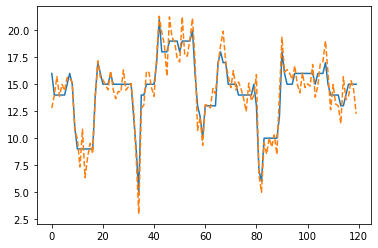

In [56]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の次元数
n_dim_series = 12
# 粒子数
n_particles = 200
# システムノイズの分散共分散行列の対角要素の値
system_sigma2 = 150

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend,
                              n_dim_obs,
                              n_dim_series,
                              Q_sigma2=system_sigma2)

observation_sigma2 = 100
transition_func = lambda x: F.dot(x)
observation_func = lambda x: H.dot(x)
system_noise = GaussianNoise(Q)
observation_noise = GaussianNoise(np.eye(n_dim_obs)*observation_sigma2)

pf = ParticleFilter(n_dim_state=n_dim_state, 
                    n_dim_obs=n_dim_obs,
                    transition_func=transition_func,
                    observation_func=observation_func,
                    system_noise=system_noise,
                    observation_noise=observation_noise,
                    n_particles=n_particles)


predicted_value = np.empty(len(train_data))
for i, d in enumerate(train_data):
    pf.update(d)
    predicted_value[i] = pf.predict()

rng = range(len(predicted_value))
plt.plot(rng, train_data, label="observation")
plt.plot(rng, predicted_value, '--', label="predict")

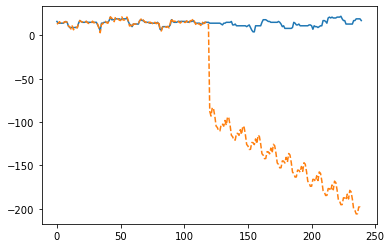

In [58]:
infered_value = np.empty(len(train_data))
for i, d in enumerate(train_data):
    infered_value[i] = pf.forecast()

rng = range(len(true_data))
plt.plot(rng, true_data, label="observation")
plt.plot(rng, 
         np.concatenate([predicted_value, infered_value]), 
         '--', label="forecast")

In [59]:
#3,3,4

In [60]:
# 推移行列などの初期化
# 観測値は一次元とする
def FGHset(n_dim_trend, 
           n_dim_obs=1, n_dim_series=0, n_dim_ar=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0) + (n_dim_ar!=0)
    if n_dim_series>0 or n_dim_ar>0:
        n_dim_state = n_dim_trend + n_dim_series + n_dim_ar -1
    else:
        n_dim_state = n_dim_trend
        
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1

        start_elem = n_dim_trend + n_dim_series -1
        start_col = n_dim_trend + n_dim_series -1
            
    # AR成分のブロック行列の構築
    if n_dim_ar>0:
        G[start_elem, 2] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_ar): 
            F[start_elem, start_elem+i] = 0.5
        for i in range(n_dim_ar-1): 
            F[start_elem+i+1, start_elem+i] = 1

            
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [61]:
from scipy.stats import multivariate_normal, cauchy, invgamma
from numpy.random import uniform
import copy


class GaussianNoise(object):
    """多次元ガウス分布
    """
    def __init__(self, covariance, update_target_idx=None):
        self.covariance = covariance
        self.n_state = len(covariance)
        self.update_target_idx = update_target_idx

    def generate(self, n_particles):
        """ノイズの生成
        """
        return multivariate_normal.rvs(np.zeros(self.n_state), 
                                       self.covariance, n_particles).T
    
    def pdf(self, y, predicted_obs):
        """確率密度
        """
        r_y = y.reshape(y.size)
        likelihoods = np.empty(predicted_obs.shape[1])
        for i, pred_y in enumerate(predicted_obs.T):
            likelihoods[i] = multivariate_normal.pdf(r_y, 
                                                     pred_y, 
                                                     cov=self.covariance)
        return likelihoods

    def update_parameters(self, particles):
        """分散共分散行列の要素の更新
        """
        n_row = len(self.covariance)
        self.covariance[range(n_row), range(n_row)] = np.exp(
            particles[self.update_target_idx].mean(axis=1))
    

class SelfOrganizationParticleFilter(object):
    def __init__(self, 
                 n_dim_state=None, n_dim_components=None,
                 n_dim_obs=None,
                 transition_func=None, transition_matrix=None,
                 observation_func=None, observation_matrix=None,
                 system_noise=None, observation_noise=None,
                 ar_param_noise=None, n_particles=None,
                 ar_param_idxs=None, ar_param_func=None,
                 Q_param_noise=None, Q_param_idxs=None):
        # 観測データの次元数
        self.n_dim_obs = n_dim_obs
        # 粒子の数
        self.n_particles = n_particles
        # リサンプリングに使用するクシ（使い回す）
        self.TEETH = np.arange(0, 1, float(1.0)/n_particles)
        # 粒子の単位質量（観測データへの適合度）
        self.weights = np.zeros(n_particles)
        # 粒子
        self.particles = np.zeros((n_dim_state, n_particles))
        # 予測分布（粒子）
        self.predicted_particles = np.zeros((n_dim_state, n_particles))
        self.n_dim_components = n_dim_components

        self.transition_func = transition_func
        self.transition_matrix = transition_matrix
        self.observation_func = observation_func
        self.observation_matrix = observation_matrix
        self.system_noise = system_noise
        self.observation_noise = observation_noise
        self.ar_param_noise = ar_param_noise
        self.ar_param_func = ar_param_func
        self.Q_param_noise = Q_param_noise

        self._init_praticles_distribution()
        self._ar_param_idxs = ar_param_idxs
        self._Q_param_idxs = Q_param_idxs
        self.n_target_params = \
            n_dim_state - len(ar_param_idxs) - len(Q_param_idxs)
        self.start_ar_dim = \
            n_dim_state - len(ar_param_idxs) * 2 - len(Q_param_idxs)
        
    def _init_praticles_distribution(self):
        """粒子の初期化
        x_{0|0}
        """
        self.particles = np.concatenate(
            [self.system_noise.generate(self.n_particles),
             self.ar_param_noise.generate(self.n_particles),
             self.Q_param_noise.generate(self.n_particles)],
            axis=0)

    def _update_transition_matrix(self):
        """遷移行列の更新（AR成分の更新）
        """
        for i, ar_idx in enumerate(self._ar_param_idxs):
            target_idx = self.start_ar_dim + i
            self.transition_matrix[self.start_ar_dim, target_idx] = \
                self.ar_param_func(self.particles[ar_idx].mean())
    
    def update(self, y):
        """リサンプリング
        """
        if isinstance(y, float):
            y = np.array([y])
        self._update_transition_matrix()
        self.system_noise.update_parameters(self.particles)
        self._update_particles()
        self._update_particles_weight(y)
        self._resample()

    def forecast(self):
        """長期予測
        """
        self.particles[:self.n_target_params] = \
            self.transition_func(self.particles[:self.n_target_params], 
                                 self.transition_matrix)
        return self.observation_func(self.particles[:self.n_target_params], 
                                     self.observation_matrix).mean(axis=1)

    def generate_system_noise(self):
        """v_t"""
        return self.system_noise.generate(self.n_particles)        
    
    def _update_particles(self):
        """システムモデルの計算（新たな粒子を生成することで予測分布を計算）
        x_{t|t-1}
        """
        # ハイパーパラメタ以外の予測分布
        par = (self.particles[:self.n_target_params] 
               + self.generate_system_noise())
        self.predicted_particles[:self.n_target_params] = \
            self.transition_func(par, self.transition_matrix)

        # ハイパーパラメタの粒子の予測分布
        # AR成分の予測分布
        self.predicted_particles[self._ar_param_idxs] = \
            (self.predicted_particles[self._ar_param_idxs]
             + self.ar_param_noise.generate(self.n_particles))

        # システムノイズの対角成分の予測分布
        self.predicted_particles[self._Q_param_idxs] = \
            (self.predicted_particles[self._Q_param_idxs]
             + self.Q_param_noise.generate(self.n_particles))
                        
    def _update_particles_weight(self, y):
        """各粒子の重みの計算（予測値が観測値に対してどれだけ適合しているかを計算）
        w_t
        """
        self.weights = self.observation_noise.pdf(
            y, self.observation_func(
                self.predicted_particles[:self.n_target_params], 
                self.observation_matrix))
        
    def _normalize_weights(self):
        """\tild{w}_t"""
        self.weights = self.weights / sum(self.weights)

    def _resample(self):
        """x_{t|t}"""
        self._normalize_weights()
        cum = np.cumsum(self.weights)
        
        # ルーレットを回す（粒子をランダムに選定するためのポインター生成）
        base = uniform(0, float(1.0)/self.n_particles)
        pointers = self.TEETH + base

        # 粒子の選定
        selected_idx = [np.where(cum>=p)[0][0] for p in pointers]
        self.particles = self.predicted_particles[:, selected_idx]

    def predict(self):
        """フィルタ系列の推定
        """
        pre_targete_dim = 0
        target_dim = 0
        results = []
        for n_dim_each in self.n_dim_components:
            target_dim += n_dim_each
            H = self.observation_matrix[:, pre_targete_dim:target_dim]
            matmul = self.observation_func(
                self.predicted_particles[pre_targete_dim:target_dim], 
                H)
            weighted = matmul * self.weights
            pre_targete_dim = target_dim
            results.append(np.sum(weighted, axis=1))
        return results

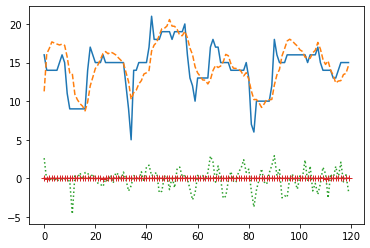

In [64]:
np.random.seed(555)

# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の
n_dim_series = 12
# AR成分の次数
n_dim_ar = 2
# 数値予測の際に成分を分けるため各成分の要素数を格納
n_dim_components = (n_dim_trend, n_dim_series-1, n_dim_ar)
# 粒子数
n_particles = 1000
# システムノイズの分散共分散行列の各要素の値
system_sigma2 = 1500

n_dim_state, F, H, Q = FGHset(n_dim_trend, 
                              n_dim_obs, 
                              n_dim_series, 
                              n_dim_ar, 
                              Q_sigma2=system_sigma2)

# 自己組織化するハイパーパラメタに該当する粒子のindex
ar_param_idxs = [idx for idx in range(n_dim_state, n_dim_state + n_dim_ar)]
Q_param_idxs = [idx for idx in range(ar_param_idxs[-1] + 1,
                                     ar_param_idxs[-1] + 1 + len(Q))]
n_dim_state += len(ar_param_idxs)
n_dim_state += len(Q_param_idxs)

# 観測ノイズの分散共分散行列の各要素の値
# 小さければ観測データに忠実にフィットしやすい
observation_sigma2 = 400

# AR係数はtanhで[-1, 1]の範囲で推定する
# そのためランダムウォークの分散はtanhの逆関数の出力とする
inv_tanh = lambda x: 0.5 * np.log((1 + x) / (1 - x))
ar_params_sigma2 = inv_tanh(0.25)

# システムノイズの分散共分散行列の要素は非負であり、推定時にはexp(x)とする
# そのためランダムウォークの分散は自然対数とする
# 大きくし過ぎると発散しやすい
Q_params_sigma2 = np.log(25)

# システム関数
transition_func = lambda x, F: F.dot(x)
# 観測関数
observation_func = lambda x, H: H.dot(x)
# システムノイズオブジェクトのインスタンス生成
system_noise = GaussianNoise(Q, Q_param_idxs)
# 観測ノイズオブジェクトのインスタンス生成
observation_noise = GaussianNoise(
    np.eye(n_dim_obs) * observation_sigma2)
# AR成分のノイズオブジェクトのインスタンス生成
ar_param_noise = GaussianNoise(
    np.eye(len(ar_param_idxs)) * ar_params_sigma2)
# AR係数を推定する際の復元関数
ar_param_func = lambda x: np.tanh(x)
# システムノイズ共分散行列の要素のノイズオブジェクトのインスタンス生成
Q_param_noise = GaussianNoise(np.eye(len(Q_param_idxs)) * Q_params_sigma2)

pf = SelfOrganizationParticleFilter(n_dim_state=n_dim_state, 
                                    n_dim_components=n_dim_components,
                                    n_dim_obs=n_dim_obs,
                                    transition_func=transition_func,
                                    transition_matrix=F,
                                    observation_func=observation_func,
                                    observation_matrix=H,
                                    system_noise=system_noise,
                                    observation_noise=observation_noise,
                                    ar_param_noise=ar_param_noise,
                                    n_particles=n_particles,
                                    ar_param_idxs=ar_param_idxs,
                                    ar_param_func=ar_param_func,
                                    Q_param_noise=Q_param_noise,
                                    Q_param_idxs=Q_param_idxs)

n_train = 120
predicted_trend = np.empty(n_train)
predicted_seasonal = np.empty(n_train)
predicted_ar = np.empty(n_train)
for i, d in enumerate(train_data):
    pf.update(d)
    results = pf.predict()
    predicted_trend[i] = results[0]
    predicted_seasonal[i] = results[1]
    predicted_ar[i] = results[2]

rng = range(n_train)
plt.plot(rng, train_data, label="observation")
plt.plot(rng, predicted_trend, '--', label="trend")
plt.plot(rng, predicted_seasonal, ':', label="seasonal")
plt.plot(rng, predicted_ar, '+-', label="ar")

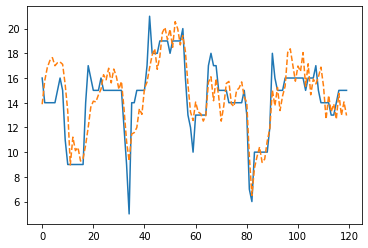

In [65]:
rng = range(n_train)
predicted = predicted_trend + predicted_seasonal + predicted_ar
plt.plot(rng, train_data, label="observation")
plt.plot(rng, predicted, '--', label="predict")

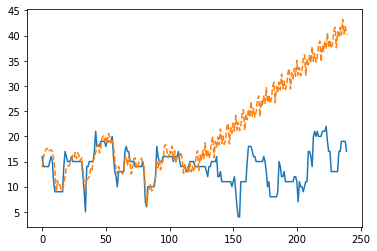

In [66]:
infered_value = np.empty(len(train_data))
for i, d in enumerate(train_data):
    infered_value[i] = pf.forecast()

rng = range(len(true_data))
plt.plot(rng, true_data, label="observation")
plt.plot(rng, 
         np.concatenate([predicted, infered_value]), 
         '--', label="forecast")

In [67]:
#3.3.5

In [68]:
# 推移行列などの初期化
# 観測値は一次元とする
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series -1
    else:
        n_dim_state = n_dim_trend
       
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1
    
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [69]:
from scipy.stats import multivariate_normal, cauchy
from numpy.random import uniform


class GaussianNoise(object):
    """多次元ガウス分布
    """
    def __init__(self, covariance):
        self.covariance = covariance
        self.n_state = len(covariance)

    def generate(self, n_particles):
        """ノイズの生成
        """
        return (multivariate_normal.rvs(
            np.zeros(self.n_state), self.covariance, n_particles).T)
        
    def pdf(self, y, predicted_obs):
        """確率密度
        """
        r_y = y.reshape(y.size)
        likelihoods = np.empty(predicted_obs.shape[1])
        for i, pred_y in enumerate(predicted_obs.T):
            likelihoods[i] = multivariate_normal.pdf(r_y, 
                                                     pred_y, 
                                                     cov=self.covariance)
        return likelihoods

    def update_parameters(self, particles, target_idxs):
        for i in range(len(self.covariance)):
            self.covariance[i, i] = particles[target_idxs[i]].mean()


class FixedLagParticleFilter(object):
    def __init__(self, 
                 n_dim_state=None, n_dim_obs=None,
                 transition_func=None, observation_func=None,
                 system_noise=None, observation_noise=None,
                 n_particles=None):
        # 観測データの次元数
        self.n_dim_obs = n_dim_obs
        # 粒子の数
        self.n_particles = n_particles
        # リサンプリングに使用する横櫛（使い回す）
        self.TEETH = np.arange(0, 1, float(1.0)/n_particles)
        # 粒子の単位質量（観測データへの適合度）
        self.weights = np.zeros(n_particles)
        # 粒子
        self.particles = np.zeros((n_dim_state, n_particles))
        # 予測分布（粒子）
        self.predicted_particles = np.zeros((n_dim_state, n_particles))

        self.transition_func = transition_func
        self.observation_func = observation_func
        self.system_noise = system_noise
        self.observation_noise = observation_noise
        
        self._init_praticles_distribution()

    def _init_praticles_distribution(self):
        """粒子の初期化
        x_{0|0}
        """
        self.particles = self.system_noise.generate(self.n_particles)

    def update(self, y):
        """リサンプリング
        """
        if isinstance(y, float):
            y = np.array([y])
        self._update_particles()
        self._update_particles_weight(y)
        self._resample()

    def forecast(self):
        """長期予測
        """
        self.particles = self.transition_func(self.particles)
        return self.observation_func(self.particles).mean(axis=1)

    def generate_system_noise(self):
        """v_t"""
        return self.system_noise.generate(self.n_particles)

    def _update_particles(self):
        """システムモデルの計算（新たな粒子を生成することで予測分布を計算）
        x_{t|t-1}
        """
        self.predicted_particles = \
            self.transition_func(self.particles) + self.generate_system_noise()

    def _update_particles_weight(self, y):
        """各粒子の重みの計算（予測値が観測値に対してどれだけ適合しているかを計算）
        w_t
        """
        self.weights = self.observation_noise.pdf(
                y, self.observation_func(self.predicted_particles))
        
    def _normalize_weights(self):
        """\tild{w}_t"""
        self.weights = self.weights / sum(self.weights)

    def _resample(self):
        """x_{t|t}"""
        self._normalize_weights()

        # accumulate weight
        cum = np.cumsum(self.weights)

        # create roulette pointer 
        base = uniform(0, float(1.0)/self.n_particles)
        pointers = self.TEETH + base

        # select particles
        self.selected_idx = [np.where(cum>=p)[0][0] for p in pointers]
        self.particles = self.predicted_particles[:, self.selected_idx]

    def predict(self):
        """フィルタ系列の予測
        """
        return (np.sum(
            self.observation_func(self.predicted_particles) * self.weights,
            axis=1))

    def fl_smoothing(self, past_particles, lag):
        """固定ラグ平滑化
        """
        # 平滑化分布
        smoothed = np.empty([lag, self.n_dim_obs, self.n_particles])
        for lg in range(lag):
            smoothed[lg] = self.observation_func(
                past_particles[lg, :, self.selected_idx].T)
        return smoothed

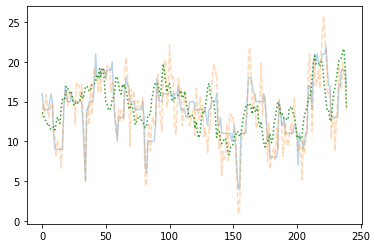

In [70]:
np.random.seed(555)

n_dim_trend = 2
n_dim_obs = 1
n_dim_series = 12
n_particles = 200
system_sigma2 = 200

n_dim_state, F, H, Q = FGHset(n_dim_trend, 
                              n_dim_obs, 
                              n_dim_series, 
                              Q_sigma2=system_sigma2)

observation_sigma2 = 300
params_sigma2 = 150
transition_func = lambda x: F.dot(x)
observation_func = lambda x: H.dot(x)
system_noise = GaussianNoise(Q)
observation_noise = GaussianNoise(np.eye(n_dim_obs)*observation_sigma2)

pf = FixedLagParticleFilter(n_dim_state=n_dim_state, 
                            n_dim_obs=n_dim_obs,
                            transition_func=transition_func,
                            observation_func=observation_func,
                            system_noise=system_noise,
                            observation_noise=observation_noise,
                            n_particles=n_particles)

y = np.concatenate([np.random.normal(0,50,size=70), 
                    np.random.normal(100,50,size=100)])
# 長期予測結果の保存ベクトル
predicted = np.empty(len(true_data))
# 平滑化系列の保存ベクトル
smoothed = np.empty(len(true_data))

n_lag = 10
past_particles = np.empty([n_lag, n_dim_state, n_particles])

for i, d in enumerate(true_data):
    pf.update(d)
    predicted[i] = pf.predict()
    # ラグ数分のデータがたまった後は平滑化分布をもとにt-Lの値を計算
    if i>n_lag-1:
        smoothed_values = pf.fl_smoothing(past_particles, n_lag)
        smoothed[i-n_lag] = smoothed_values.mean(axis=(0,2))
        # 最終時点に到達した場合
        if i==len(true_data)-1:
            smoothed[i] = predicted[i]
            for i_lag in range(1, n_lag):
                smoothed[i-i_lag] = \
                    smoothed_values[-i_lag:].mean(axis=(0,2))      
        past_particles[:-1] = past_particles[1:][:, :, pf.selected_idx]
        past_particles[-1] = pf.particles
        
    # ラグ数分のデータがたまるまでは過去分の粒子を保存するだけ
    else:
        past_particles = past_particles[:, :, pf.selected_idx]
        past_particles[i] = pf.particles
            
rng = range(len(predicted))
plt.plot(rng, true_data, label="observation", alpha=0.3)
plt.plot(rng, predicted, '--', label="predict", alpha=0.3)
plt.plot(rng, smoothed, ':', label="smoothed")

In [71]:
#3.3.6

In [72]:
# 推移行列などの初期化
# 観測値は一次元とする
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, n_dim_ar=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0) + (n_dim_ar!=0)
    if n_dim_series>0 or n_dim_ar>0:
        n_dim_state = n_dim_trend + n_dim_series + n_dim_ar -1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1

        start_elem = n_dim_trend + n_dim_series -1
        start_col = n_dim_trend + n_dim_series -1
            
    # AR成分のブロック行列の構築
    if n_dim_ar>0:
        G[start_elem, 2] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_ar): 
            F[start_elem, start_elem+i] = 0.5
        for i in range(n_dim_ar-1): 
            F[start_elem+i+1, start_elem+i] = 1

            
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [73]:
np.random.seed(555)

n_dim_trend = 2
n_dim_obs = 1
# 季節成分の
n_dim_series = 12
# AR成分の次数
n_dim_ar = 2
# 数値予測の際に成分を分けるため各成分の要素数を格納
n_dim_components = (n_dim_trend, n_dim_series-1, n_dim_ar)
# 粒子数
n_particles = 1000
# システムノイズの分散共分散行列の各要素の値
system_sigma2 = 1500

n_dim_state, F, H, Q = FGHset(n_dim_trend, 
                              n_dim_obs, 
                              n_dim_series, 
                              n_dim_ar, 
                              Q_sigma2=system_sigma2)

# 自己組織化するハイパーパラメタに該当する粒子のindex
ar_param_idxs = [idx for idx in range(n_dim_state, 
                                      n_dim_state + n_dim_ar)]
Q_param_idxs = [idx for idx in range(ar_param_idxs[-1] + 1, 
                                     ar_param_idxs[-1] + 1 + len(Q))]
n_dim_state += len(ar_param_idxs)
n_dim_state += len(Q_param_idxs)

# 観測ノイズの分散共分散行列の各要素の値
# 小さければ観測データに忠実にフィットしやすい
observation_sigma2 = 400

# AR係数はtanhで[-1, 1]の範囲で推定する
# そのためランダムウォークの分散はtanhの逆関数の出力とする
inv_tanh = lambda x: 0.5 * np.log((1 + x) / (1 - x))
ar_params_sigma2 = inv_tanh(0.25)

# システムノイズの分散共分散行列の要素は非負であり、推定時にはexp(x)とする
# そのためランダムウォークの分散は自然対数とする
# 大きくし過ぎると発散しやすい
Q_params_sigma2 = np.log(25)

# システム関数
transition_func = lambda x, F: F.dot(x)
# 観測関数
observation_func = lambda x, H: H.dot(x)
# システムノイズオブジェクトのインスタンス生成
system_noise = GaussianNoise(Q, Q_param_idxs)
# 観測ノイズオブジェクトのインスタンス生成
observation_noise = GaussianNoise(
    np.eye(n_dim_obs) * observation_sigma2)
# AR成分のノイズオブジェクトのインスタンス生成
ar_param_noise = GaussianNoise(
    np.eye(len(ar_param_idxs)) * ar_params_sigma2)
# AR係数を推定する際の復元関数
ar_param_func = lambda x: np.tanh(x)
# システムノイズ共分散行列の要素のノイズオブジェクトのインスタンス生成
Q_param_noise = GaussianNoise(
    np.eye(len(Q_param_idxs)) * Q_params_sigma2)

pf = SelfOrganizationParticleFilter(n_dim_state=n_dim_state, 
                                    n_dim_components=n_dim_components,
                                    n_dim_obs=n_dim_obs,
                                    transition_func=transition_func,
                                    transition_matrix=F,
                                    observation_func=observation_func,
                                    observation_matrix=H,
                                    system_noise=system_noise,
                                    observation_noise=observation_noise,
                                    ar_param_noise=ar_param_noise,
                                    n_particles=n_particles,
                                    ar_param_idxs=ar_param_idxs,
                                    ar_param_func=ar_param_func,
                                    Q_param_noise=Q_param_noise,
                                    Q_param_idxs=Q_param_idxs)


n_train = 120
predicted_trend = np.empty(n_train)
predicted_seasonal = np.empty(n_train)
predicted_ar = np.empty(n_train)
p_lower = np.empty(n_train)
p_upper = np.empty(n_train)
for i, d in enumerate(train_data):
    pf.update(d)
    results, lower, upper = pf.predict()
    predicted_trend[i] = results[0]
    predicted_seasonal[i] = results[1]
    predicted_ar[i] = results[2]
    
    p_lower[i] = np.sum(lower)
    p_upper[i] = np.sum(upper)
    
rng = range(n_train)
plt.plot(rng, train_data, label="observation")
plt.plot(rng, predicted_trend, '--', label="trend")
plt.plot(rng, predicted_seasonal, ':', label="seasonal")
plt.plot(rng, predicted_ar, '+-', label="ar")

TypeError: __init__() takes 2 positional arguments but 3 were given